In [33]:
import numpy as np
import matplotlib.pyplot as plt

def computeH(im1_pts, im2_pts):
    n = len(im1_pts)
    A = np.zeros((2 * n, 8))
    b = np.zeros((2 * n, 1))

    for i in range(n):
        x, y = im1_pts[i]
        xp, yp = im2_pts[i]
        A[2*i]   = [x, y, 1, 0, 0, 0, -x*xp, -y*xp]
        A[2*i+1] = [0, 0, 0, x, y, 1, -x*yp, -y*yp]
        b[2*i]   = xp
        b[2*i+1] = yp

    # Solve Ah = b via least squares
    h, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    h = np.append(h, 1)
    H = h.reshape(3, 3)
    return H

Recovered Homography Matrix:
[[ 4.90792521e-01 -3.03338445e-01  1.61928810e+02]
 [-9.46260426e-02  4.84863462e-01  2.56664447e+02]
 [-1.41222136e-04 -2.10643213e-04  1.00000000e+00]]


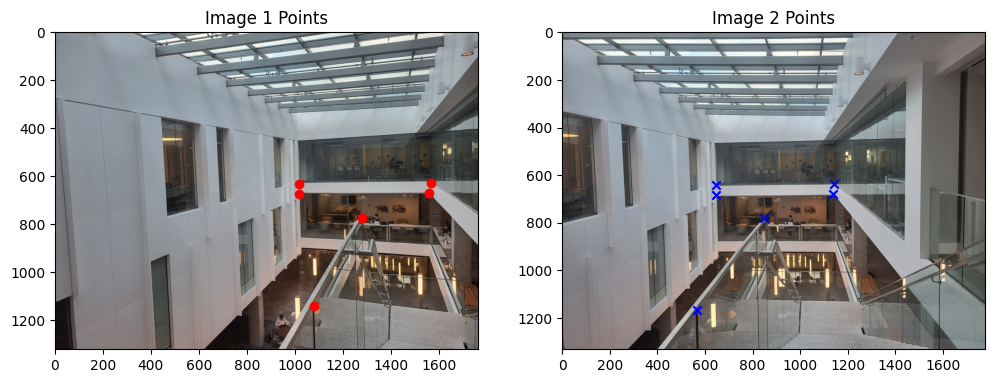

<Figure size 640x480 with 0 Axes>

In [52]:
#  Deliverables: Implement computeH(im1_pts, im2_pts) function. Show your correspondences visualized on the images, system of equations, and recovered homography matrix. 
import json
from utils import show_image

with open("data/bair53_bair52.json") as f:
    data = json.load(f)

im1_name = data["im1_name"]
im2_name = data["im2_name"]
im1Points = np.array(data["im1Points"])
im2Points = np.array(data["im2Points"])

im1 = plt.imread(f"data/{im1_name}.jpg")
im2 = plt.imread(f"data/{im2_name}.jpg")
H = computeH(im1Points, im2Points)

print("Recovered Homography Matrix:")
print(H)


def visualize_correspondences(im1, im2, im1_pts, im2_pts):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(im1)
    axes[0].scatter(im1_pts[:, 0], im1_pts[:, 1], c='r', marker='o')
    axes[0].set_title('Image 1 Points')

    axes[1].imshow(im2)
    axes[1].scatter(im2_pts[:, 0], im2_pts[:, 1], c='b', marker='x')
    axes[1].set_title('Image 2 Points')

    plt.show()

visualize_correspondences(im1, im2, im1Points, im2Points)
plt.savefig("out/correspondences.png")

In [35]:
import numpy as np

def warpImageNearestNeighbor(im, H, output_shape=None):
    Hinv = np.linalg.inv(H)
    h, w = im.shape[:2]
    
    if output_shape is None:
        output_shape = (h, w)
    out_h, out_w = output_shape
    imwarped = np.zeros_like(im[:out_h, :out_w])

    ys, xs = np.indices((out_h, out_w))
    homog_pts = np.stack([xs.ravel(), ys.ravel(), np.ones(xs.size)])
    src = Hinv @ homog_pts
    src /= src[2, :]  # normalize

    x_src, y_src = src[0, :], src[1, :]

    x_src_round = np.round(x_src).astype(int)
    y_src_round = np.round(y_src).astype(int)

    valid = (x_src_round >= 0) & (x_src_round < w) & (y_src_round >= 0) & (y_src_round < h)
    
    imwarped[ys.ravel()[valid], xs.ravel()[valid]] = im[y_src_round[valid], x_src_round[valid]]
    return imwarped

def warpImageBilinear(im, H, output_shape=None, fill=0):
    h, w = im.shape[:2]
    if output_shape is None:
        out_h, out_w = h, w
    else:
        out_h, out_w = output_shape

    Hinv = np.linalg.inv(H)
    xs = np.arange(out_w)
    ys = np.arange(out_h)
    xs_grid, ys_grid = np.meshgrid(xs, ys, indexing='xy')
    pts = np.stack([xs_grid.ravel(), ys_grid.ravel(), np.ones(xs_grid.size)], axis=0)
    src = Hinv @ pts
    src /= src[2:3, :]

    x_src = src[0, :]
    y_src = src[1, :]

    # floor and clamped ceil (clamp so border pixels are handled)
    x0 = np.floor(x_src).astype(int)
    y0 = np.floor(y_src).astype(int)
    x1 = np.minimum(x0 + 1, w - 1)
    y1 = np.minimum(y0 + 1, h - 1)

    # valid if top-left is inside image bounds
    valid = (x0 >= 0) & (y0 >= 0) & (x0 < w) & (y0 < h)

    dx = x_src - x0  # fractional part in x
    dy = y_src - y0  # fractional part in y

    im_float = im.astype(np.float64)

    if im.ndim == 3:
        out = np.full((out_h * out_w, im.shape[2]), fill, dtype=np.float64)
        for c in range(im.shape[2]):
            channel = im_float[..., c]
            Ia = channel[y0[valid], x0[valid]]  # top-left
            Ib = channel[y0[valid], x1[valid]]  # top-right (clamped)
            Ic = channel[y1[valid], x0[valid]]  # bottom-left
            Id = channel[y1[valid], x1[valid]]  # bottom-right
            wx = dx[valid]
            wy = dy[valid]
            vals = (1 - wx) * (1 - wy) * Ia + \
                   wx * (1 - wy) * Ib + \
                   (1 - wx) * wy * Ic + \
                   wx * wy * Id
            out[valid, c] = vals
        out_img = out.reshape((out_h, out_w, im.shape[2]))
        # cast back to original dtype (with clipping for integer types)
        if np.issubdtype(im.dtype, np.integer):
            info = np.iinfo(im.dtype)
            out_img = np.clip(out_img, info.min, info.max).astype(im.dtype)
        else:
            out_img = out_img.astype(im.dtype)
        return out_img
    else:
        out = np.full((out_h * out_w,), fill, dtype=np.float64)
        channel = im_float
        Ia = channel[y0[valid], x0[valid]]
        Ib = channel[y0[valid], x1[valid]]
        Ic = channel[y1[valid], x0[valid]]
        Id = channel[y1[valid], x1[valid]]
        wx = dx[valid]
        wy = dy[valid]
        vals = (1 - wx) * (1 - wy) * Ia + \
               wx * (1 - wy) * Ib + \
               (1 - wx) * wy * Ic + \
               wx * wy * Id
        out[valid] = vals
        out_img = out.reshape((out_h, out_w))
        if np.issubdtype(im.dtype, np.integer):
            info = np.iinfo(im.dtype)
            out_img = np.clip(out_img, info.min, info.max).astype(im.dtype)
        else:
            out_img = out_img.astype(im.dtype)
        return out_img

(1972, 1479, 3)


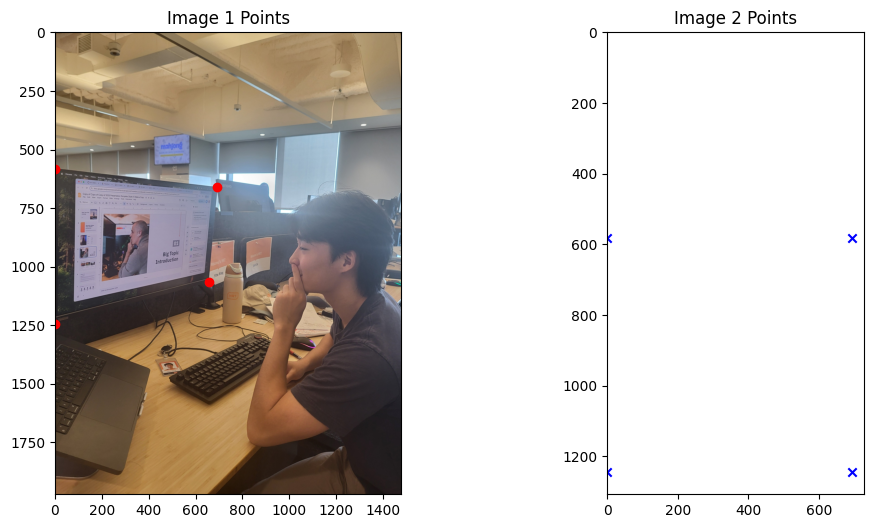

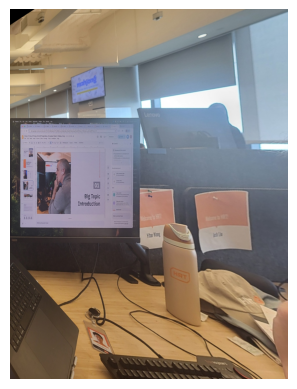

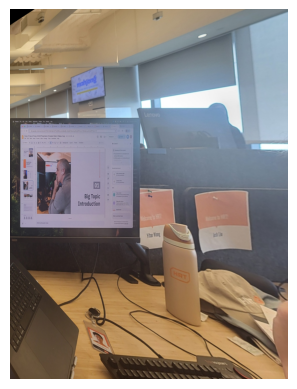

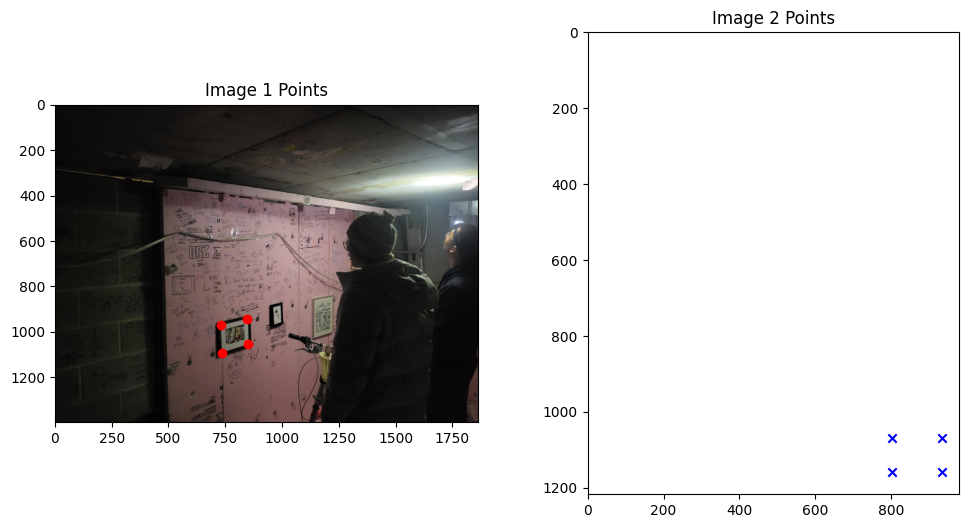

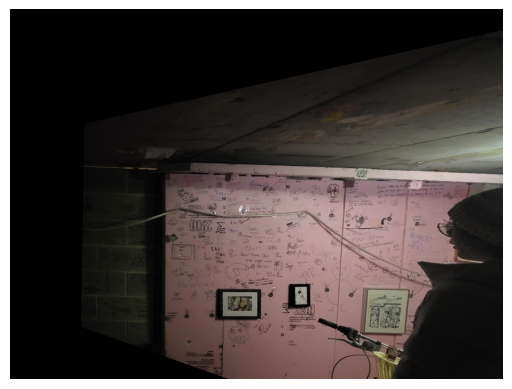

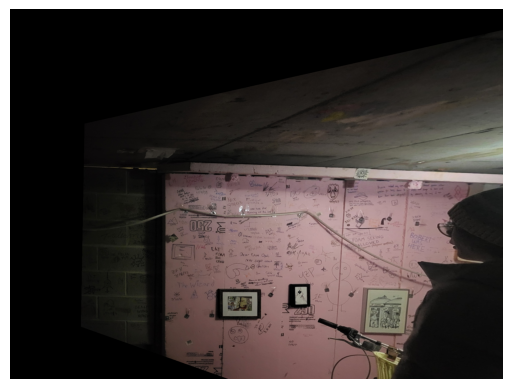

In [36]:
"""
 Rectification: Once you get this far, you should be able to test all of your code by performing “rectification” on an image. Take a photo containing paintings, posters, or any other known rectangular objects and make one of them rectangular - using a homography. You should do this before proceeding further to make sure your homography/warping is working. Note that since here you only have one image and need to compute a homography for, say, ground plane rectification (rotating the camera to point downward), you will need to define the correspondences using something you know about the image. E.g. if you know that the tiles on the floor are square, you can click on the four corners of a tile and store them in im1_pts while im2_pts you define by hand to be a square, e.g. [0 0; 0 1; 1 0; 1 1]. This is a deliverable.


Deliverables: Implement warpImageNearestNeighbor(im, H) and warpImageBilinear(im, H) using inverse warping. Apply to 2+ images for rectification. Show comparisons.
"""

im = plt.imread("data/big_topic_intro.jpg")
im = np.rot90(im, k=-1)
print(im.shape)
im1_pts = np.array([[0, 1245], [0, 581], [692, 662], [656, 1067]])
im2_pts = np.round(np.array([[0, 1245], [0, 581], [692, 581], [692, 1245]]) * 1) 
visualize_correspondences(im, np.zeros((1,1,3)), im1_pts, im2_pts)
H = computeH(im1_pts, im2_pts)

warped_nn = warpImageNearestNeighbor(im, H)
show_image(warped_nn, "out/big_topic_intro_nn_warp.jpg")
warped_bilinear = warpImageBilinear(im, H)
show_image(warped_bilinear, "out/big_topic_intro_bilinear_warp.jpg")


im = plt.imread('data/foam_room.jpg')
im1_pts = np.array([[730, 971], [848, 942], [852, 1054], [734, 1091]])
im2_pts = np.round(np.array([[730, 971], [848, 971], [848, 1054], [730, 1054]]) * 1.1)
visualize_correspondences(im, np.zeros((1,1,3)), im1_pts, im2_pts)
H = computeH(im1_pts, im2_pts)
warped_nn = warpImageNearestNeighbor(im, H)
show_image(warped_nn, "out/foam_room_nn_warp.jpg")
warped_bilinear = warpImageBilinear(im, H)
show_image(warped_bilinear, "out/foam_room_bilinear_warp.jpg")

In [44]:
def mosaic(ims, pts_between_ims, reference_index=0):
    """
    Build a mosaic from a list of images 'ims' and a list of adjacent correspondences
    'pts_between_ims' where pts_between_ims[i] == (pts_i, pts_{i+1}) and
    computeH(pts_i, pts_{i+1}) returns a homography mapping coordinates in image i -> image i+1.

    Returns the stitched RGB (or grayscale) image with simple overwriting (keeps behavior close to original).
    """
    n = len(ims)
    assert len(pts_between_ims) == n - 1, "pts_between_ims must be length n-1 and correspond to adjacent pairs"

    # Hs[i] maps image i -> reference coordinates
    Hs = [np.eye(3) for _ in range(n)]
    # Propagate left from reference (images with index < reference_index)
    for i in range(reference_index - 1, -1, -1):
        im_i_pts, im_ip1_pts = pts_between_ims[i]   # pts in image i and image i+1
        H_i_to_ip1 = computeH(np.array(im_i_pts), np.array(im_ip1_pts))  # i -> i+1
        # To map image i to reference: map i -> i+1 (H_i_to_ip1), then i+1 -> ref (Hs[i+1])
        Hs[i] = Hs[i + 1] @ H_i_to_ip1

    # Propagate right from reference (images with index > reference_index)
    for i in range(reference_index, n - 1):
        im_i_pts, im_ip1_pts = pts_between_ims[i]
        H_i_to_ip1 = computeH(np.array(im_i_pts), np.array(im_ip1_pts))  # i -> i+1
        # To map image i+1 to reference: first map i+1 -> i (inv), then i -> ref (Hs[i])
        Hs[i + 1] = Hs[i] @ np.linalg.inv(H_i_to_ip1)

    # Compute output canvas bounds
    corners = []
    for i, im in enumerate(ims):
        h, w = im.shape[:2]
        corner_pts = np.array([[0, 0, 1], [w - 1, 0, 1], [0, h - 1, 1], [w - 1, h - 1, 1]]).T  # pixel corners
        transformed = Hs[i] @ corner_pts
        transformed /= transformed[2, :]
        corners.append(transformed[:2, :])
    corners = np.hstack(corners)  # 2 x (4*n)
    min_xy = np.floor(corners.min(axis=1)).astype(int)
    max_xy = np.ceil(corners.max(axis=1)).astype(int)
    min_x, min_y = int(min_xy[0]), int(min_xy[1])
    max_x, max_y = int(max_xy[0]), int(max_xy[1])

    # +1 to include the last coordinate properly
    canvas_w = max_x - min_x + 1
    canvas_h = max_y - min_y + 1
    output_shape = (canvas_h, canvas_w, ims[0].shape[2]) if ims[0].ndim == 3 else (canvas_h, canvas_w)

    # Translation offset: maps reference coords -> canvas coords
    offset = np.array([[1, 0, -min_x],
                       [0, 1, -min_y],
                       [0, 0, 1]], dtype=np.float64)

    # Initialize canvas
    out = np.zeros(output_shape, dtype=ims[0].dtype)

    for i, im in enumerate(ims):
        H_canvas = offset @ Hs[i]   # maps source image -> canvas coordinates
        # Warp into canvas
        warped = warpImageBilinear(im, H_canvas, output_shape=output_shape[:2], fill=0)
        # Create mask of pixels that came from the warped image (any nonzero channel)
        if warped.ndim == 3:
            mask = (warped.sum(axis=2) != 0)
            out[mask] = warped[mask]
        else:
            mask = (warped != 0)
            out[mask] = warped[mask]
    return out

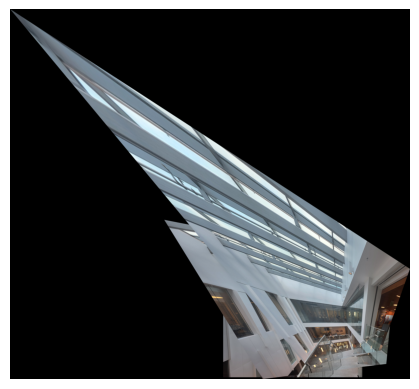

In [48]:
# Use bair51, bair52, bair53 images
im1 = plt.imread("data/bair53.jpg")
im2 = plt.imread("data/bair52.jpg")
im3 = plt.imread("data/bair51.jpg")
im_list = [im1, im2, im3]
# Read points from JSON files
with open("data/bair53_bair52.json") as f:
    data1 = json.load(f)
with open("data/bair52_bair51.json") as f:
    data2 = json.load(f)

pts_between_ims = [(data1["im1Points"], data1["im2Points"]), (data2["im1Points"], data2["im2Points"])]
m = mosaic(im_list, pts_between_ims, reference_index=0)
show_image(m, "out/bair5_mosaic.jpg")

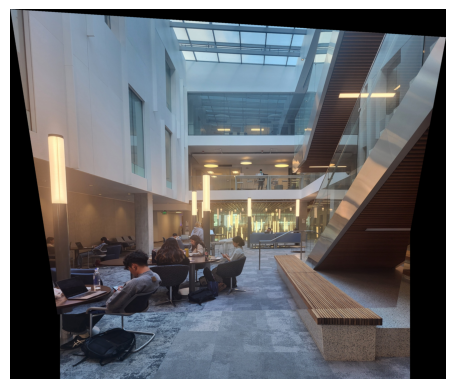

In [49]:
# Use bww31, bww32
im1 = plt.imread("data/bww31.jpg")
im2 = plt.imread("data/bww32.jpg")
im_list = [im1, im2]
# Read points from JSON file
with open("data/bww31_bww32.json") as f:
    data = json.load(f)
pts_between_ims = [(data["im1Points"], data["im2Points"])]
m = mosaic(im_list, pts_between_ims, reference_index=0)
show_image(m, "out/bww3_mosaic.jpg")

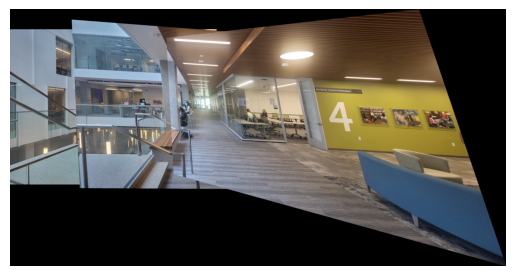

In [50]:
# Use bww41, bww42, bww43 images
im1 = plt.imread("data/bww41.jpg")
im2 = plt.imread("data/bww42.jpg")
im3 = plt.imread("data/bww43.jpg")
im_list = [im1, im2, im3]
# Read points from JSON files
with open("data/bww41_bww42.json") as f:
    data1 = json.load(f)
with open("data/bww42_bww43.json") as f:
    data2 = json.load(f)

pts_between_ims = [(data1["im1Points"], data1["im2Points"]), (data2["im1Points"], data2["im2Points"])]
m = mosaic(im_list, pts_between_ims, reference_index=0)
show_image(m, "out/bww4_mosaic.jpg")

In [51]:
# list all files in out/
import os
for filename in os.listdir("out/"):
    print(filename)

bair51.jpg
bair52.jpg
bair53.jpg
bair5_mosaic.jpg
big_topic_intro_bilinear_warp.jpg
big_topic_intro_nn_warp.jpg
big_topic_intro_prewarp.png
bww31.jpg
bww32.jpg
bww3_mosaic.jpg
bww41.jpg
bww42.jpg
bww43.jpg
bww4_mosaic.jpg
correspondences.png
foam_room_bilinear_warp.jpg
foam_room_nn_warp.jpg
foam_room_prewarp.png
